# Spoint tutorial: Deconvolution of cell types composition on human brain Visium dataset

July 2023

Dataset: Visium slices of human dorsolateral prefrontal cortex ([here](https://zenodo.org/record/8167488)).

In [1]:
# from SPACEL.setting import set_environ_seed
# set_environ_seed()
from SPACEL import Spoint
import scanpy as sc
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in `.obs`.

In [2]:
sc_ad = sc.read_h5ad('/scratch/harsha.vasamsetti/data/visium_human_DLPFC/human_MTG_snrna_norm_by_exon.h5ad')
st_ad = sc.read_h5ad('/scratch/harsha.vasamsetti/data/visium_human_DLPFC/human_DLPFC_spatial_151676.h5ad')

sc.pp.filter_genes(st_ad,min_cells=1)  # it removes any gene that is not detected in at least one spot 
sc.pp.filter_genes(sc_ad,min_cells=1)  # it removes any gene that is not detected in at least one cell

sc.pp.filter_cells(st_ad,min_genes=1)  # it removes spot the does not have at least one gene detected
sc.pp.filter_cells(sc_ad,min_genes=1)  # it removes cells that does not have at least one gene detected 

filtered out 12226 genes that are detected in less than 1 cells
filtered out 32 genes that are detected in less than 1 cells


In [3]:
sc_ad # scRNA - cells

AnnData object with n_obs × n_vars = 47432 × 48507
    obs: 'cluster_label', 'class_label', 'subclass_label', 'cortical_layer_label', 'n_genes'
    var: 'n_cells', 'gene_length', 'exon_len'

In [4]:
st_ad # original ST data - spots 

AnnData object with n_obs × n_vars = 3460 × 21312
    obs: 'nCount_originalexp', 'nFeature_originalexp', 'orig.ident', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', '

In [5]:
sc_ad.obs["cluster_label"] # cell belongs to which type

exp_component_name
LS-15005h_S02_E1-50             Inh L2-5 VIP TOX2
LS-15005h_S03_E1-50            Inh L1 LAMP5 GGT8P
LS-15005h_S04_E1-50             Inh L1 LAMP5 NDNF
LS-15005h_S05_E1-50         Inh L1-3 VIP ZNF322P1
LS-15005h_S06_E1-50              Inh L3 VIP CBLN1
                                  ...            
SQ-80016_S92_E1-50            Inh L1-3 PAX6 NABP1
SQ-80016_S93_E1-50     Exc L2-3 LINC00507 RPL9P17
SQ-80016_S94_E1-50     Exc L2-3 LINC00507 RPL9P17
SQ-80016_S95_E1-50     Exc L2-3 LINC00507 RPL9P17
SQ-80016_S96_E1-50                  OPC L1-6 MYT1
Name: cluster_label, Length: 47432, dtype: category
Categories (120, object): ['Astro L1 FGFR3 FOS', 'Astro L1 FGFR3 MT1G', 'Astro L1-6 FGFR3 ETNPPL', 'Endo L2-5 CLDN5', ..., 'Oligo L4-6 MOBP COL18A1', 'Oligo L4-6 OPALIN', 'Peri L1-6 MUSTN1', 'VLMC L1-3 CYP1B1']

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The `celltype_key` parameter represents the column name of the cell type annotation in the `.obs` attribute of the scRNA-seq anndata object. The `sm_size` parameter controls the number of simulated spots, and it is important to have a sufficient `sm_size` for accurate prediction. However, it should be noted that increasing the `sm_size` will also increase the simulation and training time. In general, we recommend setting `sm_size` to a value greater than 100,000.

## Initialize the Spoint model

In [9]:
# deg - differentially expressed gene method
#       this tells to focus on most informative genes and ignore the rest. t-test to find "marker-genes"
#       sm_size - making 100,000 suedo spots 
import wandb
spoint_model = Spoint.init_model(sc_ad,st_ad,celltype_key='cluster_label',deg_method='t-test',sm_size=100000,
                                 use_gpu=True,
                                use_wandb=True,           # Enable wandb
                                wandb_project="spacel",   # Project name
                                wandb_name="spoint-run1"  # Run name
                                 )

TypeError: init_model() got an unexpected keyword argument 'use_wandb'

## Training the Spoint model

Here, we train the model to obtain the optimal model for cell type deconvolution. The `max_steps` parameter represents the maximum number of steps in the training process. If the `early_stop` parameter is set to `True`, the model will stop training before reaching the maximum number of steps if the model has converged.

In [7]:
spoint_model.train(max_steps=5000, batch_size=1024)

/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/harsha.vasamsetti/sample_env/lib/python3.10 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/scratch/harsha.vasamsetti/sample_env/lib/pyth

Epoch 100/100: 100%|██████████| 100/100 [03:17<00:00,  1.91s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.64e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.64e+3]


Step 1078: Test inference loss=-0.532:  22%|██▏       | 1078/5000 [07:09<26:02,  2.51it/s]


KeyboardInterrupt: 

## Visualization results

Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a `DataFrame` object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the `.obs` attribute.

In [5]:
pre = spoint_model.deconv_spatial()

In [6]:
st_ad = spoint.st_ad

We can see the result of deconvolution in the ST slice.

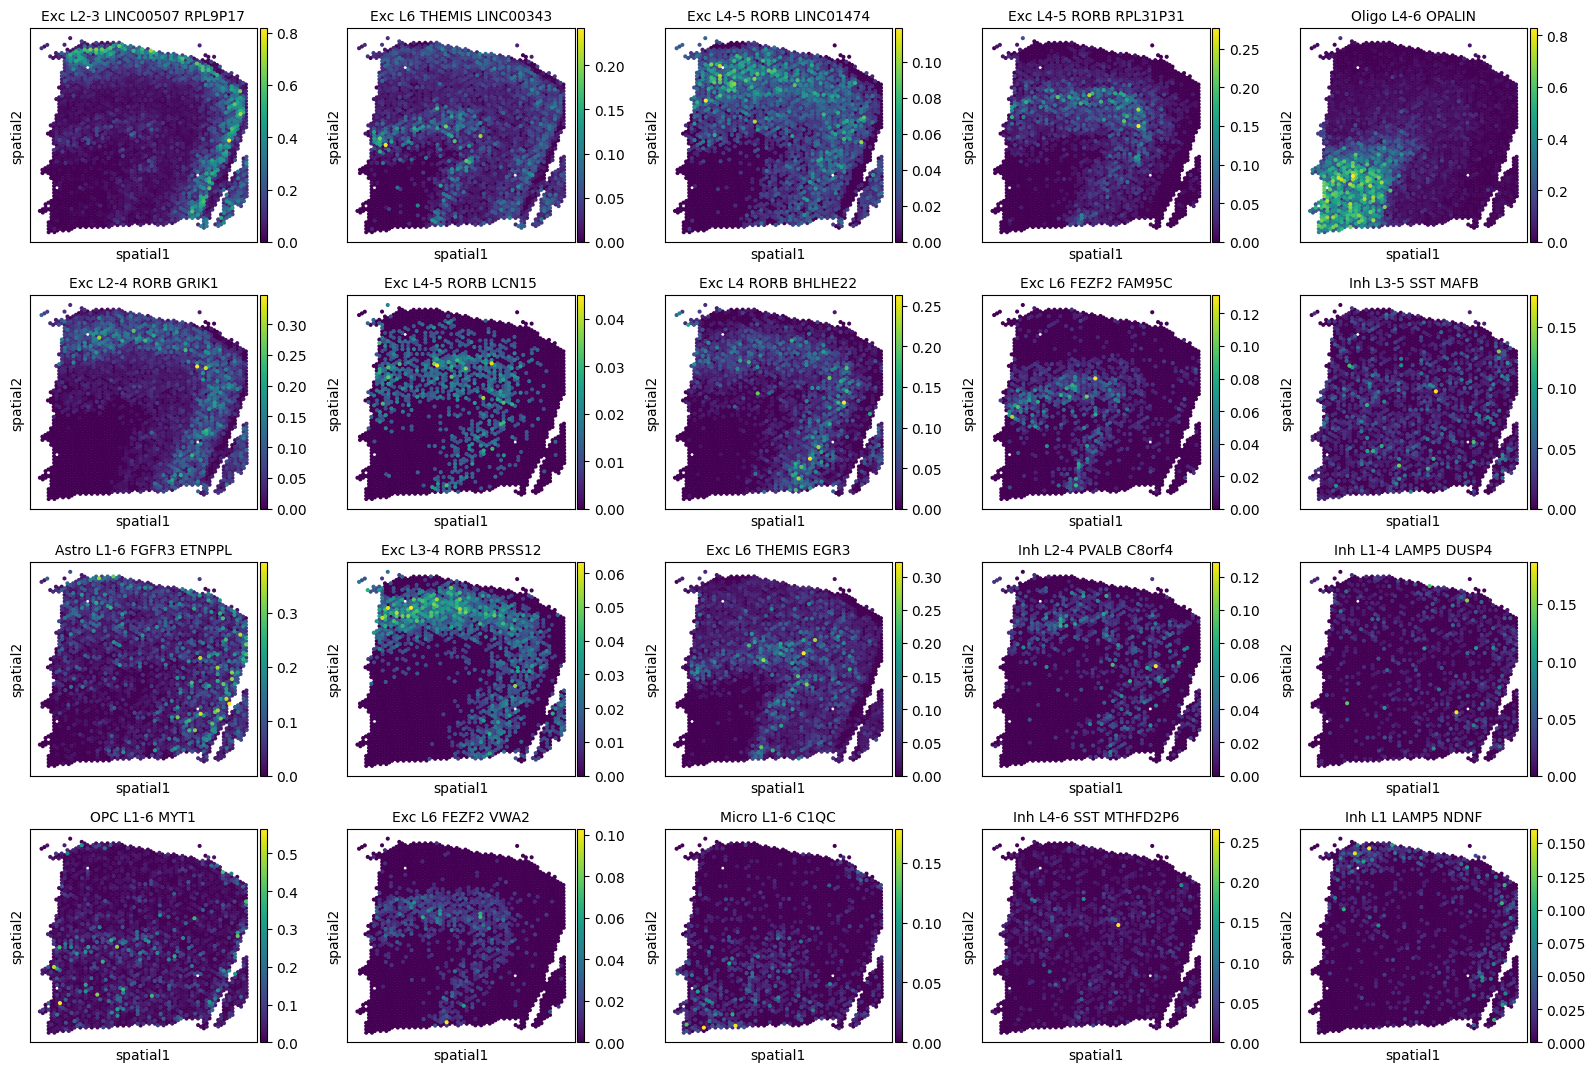

In [7]:
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5)